<a href="https://colab.research.google.com/github/BI-DS/EBA-3530/blob/main/Lecture_4/bootstrap_se_r2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import statsmodels.api as sm
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import stats

# Bootstrapping the standard errors of $\beta$ paramters

Lets use the Duncan's data set and Duncan's model
\begin{equation}
prestige = \beta_0 + \beta_1income + \beta_2 education + \epsilon \tag{1}
\end{equation}

to bootstrap the standard errors of the $\beta$ coefficients

In [ ]:
# load data set
duncan = sm.datasets.get_rdataset("Duncan" , "carData").data

1.1) Fit the Duncan's model and get the estimate for $\beta_0$

In [5]:
#@title 1.1) fit linear model
import statsmodels.formula.api as smf
ols_mod = smf.ols(formula='prestige ~ income + education', data=duncan).fit()
print(ols_mod.summary())

                            OLS Regression Results                            
Dep. Variable:               prestige   R-squared:                       0.828
Model:                            OLS   Adj. R-squared:                  0.820
Method:                 Least Squares   F-statistic:                     101.2
Date:                Wed, 28 Feb 2024   Prob (F-statistic):           8.65e-17
Time:                        21:48:20   Log-Likelihood:                -178.98
No. Observations:                  45   AIC:                             364.0
Df Residuals:                      42   BIC:                             369.4
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -6.0647      4.272     -1.420      0.1

Remember that the standard errors of $\beta_0$ can be estimated from the variance of the paratemt, which is given by

$$
 Var[\hat{\beta}] = \sigma^2(X^TX)^{-1},
$$

where $\sigma^2$ can be approximated by the residual variance, i.e.

$$
\hat{\sigma}^2 = \frac{u^Tu}{df},
$$

where $u$ are the residuals and $df$ are the degrees of freedom (number of observations minus number of paramters in the linear model).

See the file `multicollinerity.pdf` for details!

1.2) Use the bootstrap algorithm for B=1000 and N=45 and for each iteration calculate
* $Var[\hat{\beta}]$
* 95% confidence intervals

In [7]:
#@title 1.2) bootstrapping confidence intervals

# set bootstrap params
B = 1000
N = 45

# X and y for Duncan's model
y = duncan.prestige.values
x = duncan[['income','education']].values
x = sm.add_constant(x)

# list to save the bootstrapped quantity
boot_ci_lower=[]
boot_ci_upper=[]
for b in range(B):
    # sampling (only an index) with replacement
    indx_boot = np.random.choice(x.shape[0], size=N)

    # use the index to sample (with replacement) x and y
    yb   = y[indx_boot]
    xb   = x[indx_boot,:]

    # expand the dimension to get a matrix of sixe N x 1
    # so we can use matrix maltiplication later on
    yb = yb[:,None]

    # get OSL estimate via matrix formula (X'X)^(-1)X'y
    betas = np.dot(np.linalg.inv(np.dot(xb.T,xb)),np.dot(xb.T,yb))

    # predictions
    y_hat = np.matmul(xb,betas)
    residuals = yb - y_hat

    #
    residuals_var = 1/(yb.shape[0]-betas.shape[0])*np.matmul(residuals.T,residuals)

    # we only care about the main diagonal, which contains variances
    se_betas = np.sqrt(np.diag(np.linalg.inv(np.matmul(xb.T,xb))*residuals_var))[0]

    CI_upper = betas[0] + 1.96*se_betas
    CI_lower = betas[0] - 1.96*se_betas

    # append estimate
    boot_ci_lower.append(CI_lower[0])
    boot_ci_upper.append(CI_upper[0])

1.3) Plot results the bootstrapped confidence intervals together with the OLS estimate of $\beta_0$

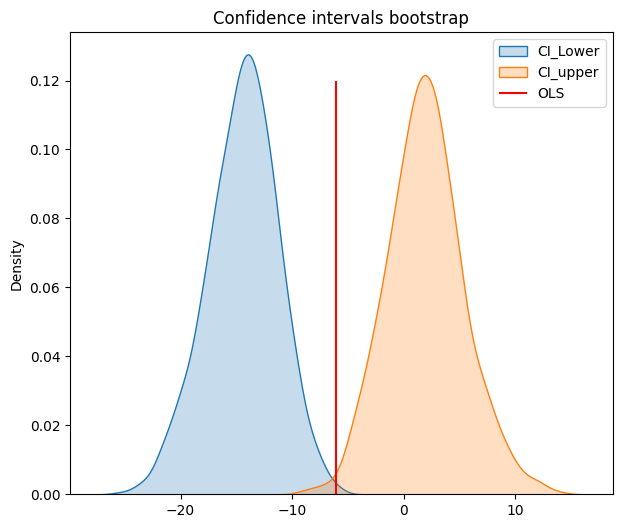

In [8]:
#@title 1.3) plot
fig, ax = plt.subplots(figsize=(7,6))
sns.kdeplot(boot_ci_lower, fill=True, ax=ax, label='CI_Lower')
sns.kdeplot(boot_ci_upper, fill=True, ax=ax, label='CI_upper')
ax.vlines(x=ols_mod.params[0],ymin=0,ymax=0.12,label='OLS',color='red')
plt.title('Confidence intervals bootstrap')
plt.legend()
plt.show()

1.4) Bootstrap the $R^2$ statistics using the formula

$$
R^2= \frac{dev_0 - dev}{dev_0}
$$

where $dev_0$ is the null deviance and $dev$ is the Duncan's model deviance (see slides for details)

In [11]:
#@title 1.4) bootstrapping R^2
boot_r2=[]
for b in range(B):
    # sampling (only an index) with replacement
    indx_boot = np.random.choice(x.shape[0], size=N)

    # use the index to sample (with replacement) x and y
    yb   = y[indx_boot]
    xb   = x[indx_boot,:]

    # expand the dimension to get a matrix of sixe N x 1
    # so we can use matrix maltiplication later on
    yb = yb[:,None]

    # get OSL estimate via matrix formula (X'X)^(-1)X'y
    betas = np.dot(np.linalg.inv(np.dot(xb.T,xb)),np.dot(xb.T,yb))
    # predictions
    y_hat = np.matmul(xb,betas)
    residuals = yb - y_hat
    # deviance
    dev = np.sum(residuals**2)
    # null deviance
    null_residuals = yb - np.mean(yb)
    dev_0 = np.sum(null_residuals**2)

    # append estimate
    r2 = (dev_0-dev)/dev_0
    boot_r2.append(r2)

1.5) plot the bootstrapped $R^2$ density together with the $R^2$ value that you obtained in the OLS model

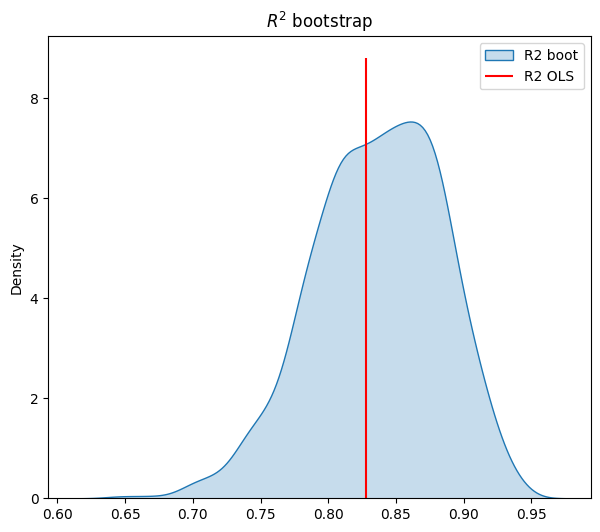

In [12]:
#@title 1.5 plot

fig = plt.figure(figsize=(7,6))
sns.kdeplot(boot_r2, fill=True, label='R2 boot')
plt.vlines(ols_mod.rsquared,ymin=0,ymax=8.8, label='R2 OLS', color='red')
plt.title(r'$R^2$ bootstrap')
plt.legend()
plt.show()